### Optimize from random noise

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
self.embedding is torch.Size([16384, 256])


Optimizing image:   0%|          | 0/10000 [00:00<?, ?it/s]

Step 0, Loss: -0.847208559513092


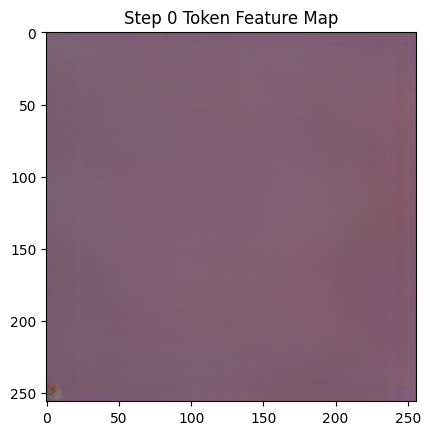

Optimizing image:   0%|          | 0/10000 [00:00<?, ?it/s]


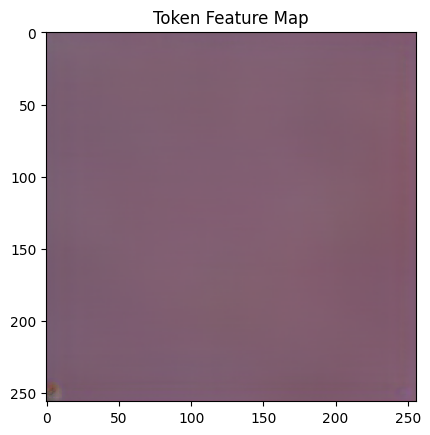

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import argparse
from tqdm import tqdm
from model import ClassificationNet1, ClassificationNet2, ClassificationNet3
import os
from omegaconf import OmegaConf
import sys
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
current_directory = os.getcwd()

# 获取父目录
parent_directory = os.path.abspath(os.path.join(current_directory, '..'))

# 添加到sys.path
sys.path.append(parent_directory)
from taming.models.new_vqgan import VQModel, GumbelVQ
from einops import rearrange
from PIL import Image
import matplotlib.pyplot as plt

rescale = lambda x: (x + 1.) / 2.

# Convert CHW tensor to a PIL image
def chw_to_pillow(x):
    return Image.fromarray((255*rescale(x.detach().cpu().numpy().transpose(1,2,0))).clip(0,255).astype(np.uint8))

# Load classification model
def load_classification_model(model_choice, model_path, device):
    num_classes = 1000  # 假设有1000个类别，可以根据实际情况调整
    if model_choice == 1:
        model = ClassificationNet1(num_classes)
    elif model_choice == 2:
        model = ClassificationNet2(num_classes)
    elif model_choice == 3:
        model = ClassificationNet3(num_classes)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Generate maximum activation image with partial optimization
def generate_max_activation_image(model, target_label, device, input_shape=(1, 256, 16, 16), lr=0.01, num_steps=10000, reg=0, VQ_model=None, mask=None):
    # Initialize input image
    input_embedding = torch.randn(input_shape, device=device, requires_grad=True)
    
    if mask is not None:
        mask = mask.to(device)

    # Define optimizer
    optimizer = torch.optim.Adam([input_embedding], lr=lr)
    
    for step in tqdm(range(num_steps), desc="Optimizing image"):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(input_embedding)
        
        # Loss function: maximize target class activation with regularization
        loss = -output[0, target_label] + reg * torch.mean(input_embedding ** 2)  # Negative activation to maximize
        
        # Backward pass
        loss.backward()
        
        if mask is not None:
            input_embedding.grad *= mask
        
        # Update input image
        optimizer.step()
        
        # Print loss
        if step % 2000 == 0:
            print(f"Step {step}, Loss: {loss.item()}")
            # Decode and visualize the current embedding
            _, _, token_feature_maps, _ = decode_input_embedding(input_embedding, VQ_model)
            for token_feature_map in token_feature_maps:
                token_feature_map_img = chw_to_pillow(token_feature_map)
                plt.imshow(token_feature_map_img)
                plt.title(f"Step {step} Token Feature Map")
                plt.show()
        return input_embedding

def load_config(config_path):
    return OmegaConf.load(config_path)

# Load VQGAN model
def load_vqgan(config, ckpt_path=None, is_gumbel=False):
    model = VQModel(**config.model.params)
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
        model.load_state_dict(sd, strict=False)
    return model.eval()

# Decode input embedding using VQGAN
def decode_input_embedding(input_embedding, VQ_model):
    codebook = VQ_model.quantize.embedding

    z = rearrange(input_embedding, 'b c h w -> b h w c').contiguous()
    z_flattened = z.view(-1, 256)
    # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

    d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
        torch.sum(codebook.weight**2, dim=1) - 2 * \
        torch.einsum('bd,dn->bn', z_flattened, rearrange(codebook.weight, 'n d -> d n'))

    min_encoding_indices = torch.argmin(d, dim=1)

    z_q = codebook(min_encoding_indices).view(z.shape)

    # reshape back to match original input shape
    z_q = rearrange(z_q, 'b h w c -> b c h w').contiguous()
    original_feature_map = VQ_model.decode(input_embedding)
    token_feature_map = VQ_model.decode(z_q)
    return z_q, min_encoding_indices, token_feature_map, original_feature_map

# Define mask to optimize specific regions
def create_mask(input_shape, top_left, bottom_right):
    mask = torch.zeros(input_shape)
    mask[:, :, top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 1
    return mask

# Main function
def main():
    model_number = 1
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    classification_model_path = f"/data/ty45972/taming-transformers/codebook_explanation_classification/checkpoints/generated_data/ClassificationNet{model_number}/best_model.pth"
    classification_model = load_classification_model(model_number, classification_model_path, device)
    
    # Define the label index and target optimization region
    target_label = 14  # Example label

    ## optimize the whole image
    # top_left = (1, 1)
    # bottom_right = (16, 16)

    # optimize the 4 * 4 region
    # top_left = (6, 6)
    # bottom_right = (9, 9)

    # optimize the 6 * 6 region
    top_left = (5, 5)
    bottom_right = (10, 10)

    # optimize the 8 * 8 region
    # top_left = (4, 4)
    # bottom_right = (11, 11)
    
    
    mask = create_mask((1, 256, 16, 16), top_left, bottom_right)
    

    
    # Load VQGAN model
    config = load_config("../logs/vqgan_imagenet_f16_16384/configs/model.yaml")
    VQ_model = load_vqgan(config, ckpt_path="../logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)
    
    optimized_image_embedding = generate_max_activation_image(classification_model, target_label, device, mask=mask, VQ_model=VQ_model)
    quantized_optimized_embedding, token_combination, token_feature_maps, _ = decode_input_embedding(optimized_image_embedding, VQ_model)

    # Generate max activation image

    
    # Visualize final results
    for token_feature_map in token_feature_maps:
        token_feature_map_img = chw_to_pillow(token_feature_map)
        plt.imshow(token_feature_map_img)
        plt.title("Token Feature Map")
        plt.show()

if __name__ == "__main__":
    main()

### Bird

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
self.embedding is torch.Size([16384, 256])


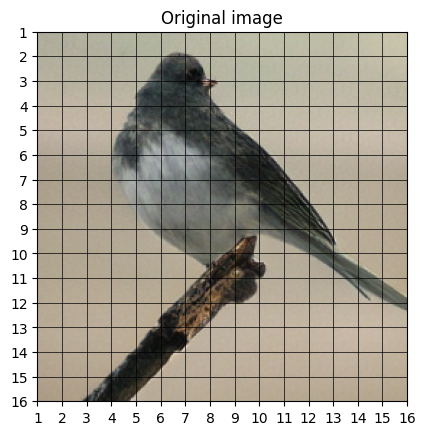

Optimizing image:   0%|          | 0/10000 [00:00<?, ?it/s]

Step 0, Loss: -12.699633598327637


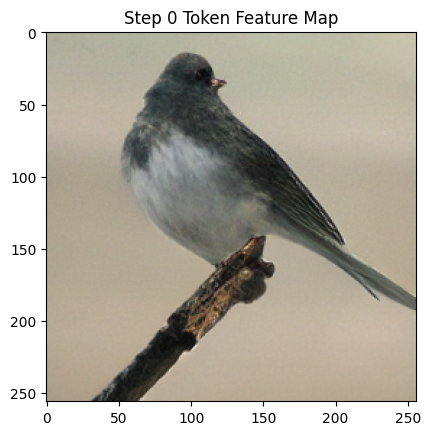

Optimizing image:   1%|          | 95/10000 [00:01<01:58, 83.24it/s]

Step 100, Loss: -22.775997161865234


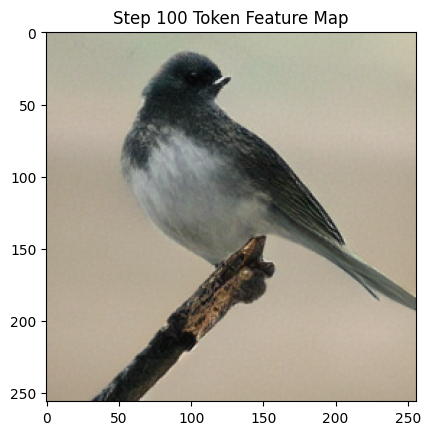

Optimizing image:   2%|▏         | 197/10000 [00:02<01:58, 82.45it/s]

Step 200, Loss: -26.29322624206543


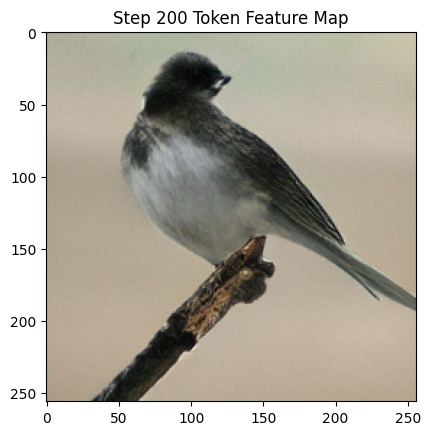

Optimizing image:   5%|▍         | 496/10000 [00:06<01:53, 83.81it/s]

Step 500, Loss: -29.37741470336914


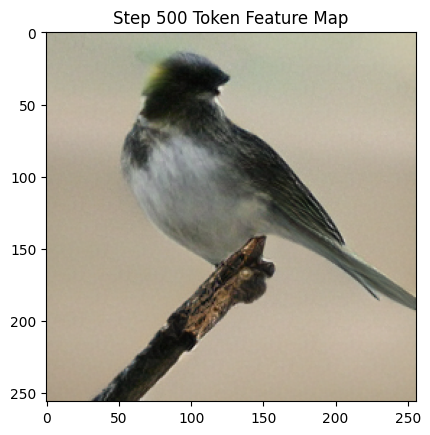

Optimizing image:  10%|▉         | 994/10000 [00:12<01:47, 84.05it/s]

Step 1000, Loss: -30.2114200592041


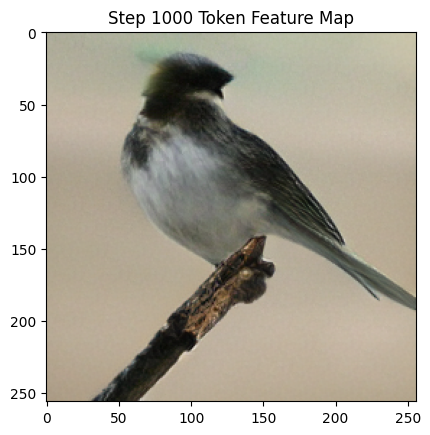

Optimizing image:  20%|█▉        | 1996/10000 [00:24<01:35, 83.90it/s]

Step 2000, Loss: -31.631845474243164


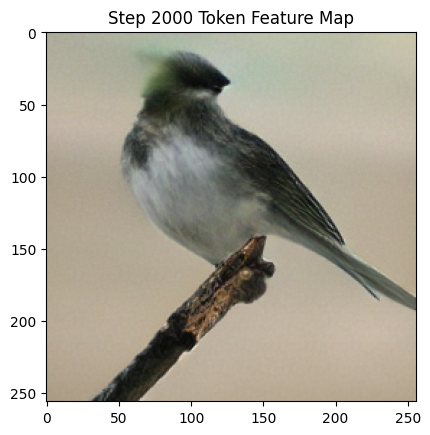

Optimizing image:  50%|████▉     | 4996/10000 [01:00<00:59, 84.03it/s]

Step 5000, Loss: -35.101417541503906


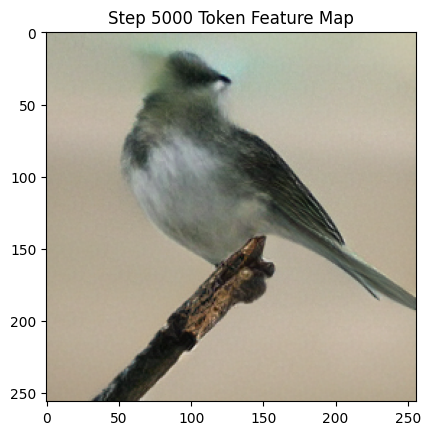

Optimizing image: 100%|██████████| 10000/10000 [02:00<00:00, 82.85it/s]


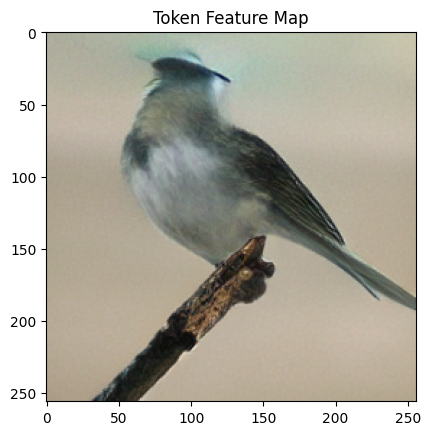

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import argparse
from tqdm import tqdm
from model import ClassificationNet1, ClassificationNet2, ClassificationNet3
import os
from omegaconf import OmegaConf
import sys
from datetime import datetime
from einops import rearrange
from PIL import Image
import matplotlib.pyplot as plt

import sys
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
current_directory = os.getcwd()

# 获取父目录
parent_directory = os.path.abspath(os.path.join(current_directory, '..'))

# 添加到sys.path
sys.path.append(parent_directory)
from taming.models.new_vqgan import VQModel, GumbelVQ
from einops import rearrange
from PIL import Image
import matplotlib.pyplot as plt

rescale = lambda x: (x + 1.) / 2.

# Convert CHW tensor to a PIL image
def chw_to_pillow(x):
    return Image.fromarray((255*rescale(x.detach().cpu().numpy().transpose(1,2,0))).clip(0,255).astype(np.uint8))

# Load classification model
def load_classification_model(model_choice, model_path, device):
    num_classes = 1000  # 假设有1000个类别，可以根据实际情况调整
    if model_choice == 1:
        model = ClassificationNet1(num_classes)
    elif model_choice == 2:
        model = ClassificationNet2(num_classes)
    elif model_choice == 3:
        model = ClassificationNet3(num_classes)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Generate maximum activation image with partial optimization
def generate_max_activation_image(model, target_label, device, input_shape=(1, 256, 16, 16), lr=0.01, num_steps=10000, reg=0, VQ_model=None, mask=None, initial_embedding=None, save_path=None):
    # Initialize input image
    input_embedding = initial_embedding.clone().detach().requires_grad_(True).to(device)
    
    if mask is not None:
        mask = mask.to(device)

    # Define optimizer
    optimizer = torch.optim.Adam([input_embedding], lr=lr)
    
    for step in tqdm(range(num_steps), desc="Optimizing image"):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(input_embedding)
        
        # Loss function: maximize target class activation with regularization
        loss = -output[0, target_label] + reg * torch.mean(input_embedding ** 2)  # Negative activation to maximize
        
        # Backward pass
        loss.backward()
        
        if mask is not None:
            input_embedding.grad *= mask
        
        # Update input image
        optimizer.step()
        
        # Save image and print loss at certain steps
        if step == 0 or step == 100 or step == 200 or step == 500 or step == 1000 or step == 2000 or step == 5000:
            print(f"Step {step}, Loss: {loss.item()}")
            # Decode and save the current embedding
            _, _, token_feature_maps, _ = decode_input_embedding(input_embedding, VQ_model)
            for i, token_feature_map in enumerate(token_feature_maps):
                token_feature_map_img = chw_to_pillow(token_feature_map)
                plt.imshow(token_feature_map_img)
                plt.title(f"Step {step} Token Feature Map")
                save_image(token_feature_map_img, save_path, step)
                plt.show()

    return input_embedding

def save_image(image, save_path, step):
    image_file = os.path.join(save_path, f"{step}.png")
    image.save(image_file)

def load_config(config_path):
    return OmegaConf.load(config_path)

# Load VQGAN model
def load_vqgan(config, ckpt_path=None, is_gumbel=False):
    model = VQModel(**config.model.params)
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
        model.load_state_dict(sd, strict=False)
    return model.eval()

# Decode input embedding using VQGAN
def decode_input_embedding(input_embedding, VQ_model):
    codebook = VQ_model.quantize.embedding

    z = rearrange(input_embedding, 'b c h w -> b h w c').contiguous()
    z_flattened = z.view(-1, 256)

    d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
        torch.sum(codebook.weight**2, dim=1) - 2 * \
        torch.einsum('bd,dn->bn', z_flattened, rearrange(codebook.weight, 'n d -> d n'))

    min_encoding_indices = torch.argmin(d, dim=1)

    z_q = codebook(min_encoding_indices).view(z.shape)

    # reshape back to match original input shape
    z_q = rearrange(z_q, 'b h w c -> b c h w').contiguous()
    original_feature_map = VQ_model.decode(input_embedding)
    token_feature_map = VQ_model.decode(z_q)
    return z_q, min_encoding_indices, token_feature_map, original_feature_map

# Define mask to optimize specific regions
def create_mask(input_shape, top_left, bottom_right):
    mask = torch.zeros(input_shape)
    mask[:, :, top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 1
    return mask

# Main function
def main():
    model_number = 1
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    classification_model_path = f"/data/ty45972/taming-transformers/codebook_explanation_classification/checkpoints/generated_data/ClassificationNet{model_number}/best_model.pth"
    classification_model = load_classification_model(model_number, classification_model_path, device)
    
    # Define the label index and target optimization region
    target_label = 19 # Example label
    original_label = 13  # Example original label

    # optimize the face region
    top_left = (1, 4)
    bottom_right = (4, 9)
    
    # optimize the body
    # top_left = (4, 4)
    # bottom_right = (12, 16)

    mask = create_mask((1, 256, 16, 16), top_left, bottom_right)
    
    # Create the directory for saving images
    save_dir = f"outputs/{original_label}_{target_label}_{top_left[0]}_{top_left[1]}"
    os.makedirs(save_dir, exist_ok=True)

    # Load VQGAN model
    config = load_config("../logs/vqgan_imagenet_f16_16384/configs/model.yaml")
    VQ_model = load_vqgan(config, ckpt_path="../logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)
    
    original_image_file = f"/data/ty45972/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_generated/{original_label}/000003.npy"
    image_array = np.load(original_image_file)
    original_image_tensor = torch.tensor(image_array).unsqueeze(0).to(device)
    _, _, original_images, _ = decode_input_embedding(original_image_tensor, VQ_model)
    for original_image in original_images:
        image = chw_to_pillow(original_image)
        plt.imshow(image, extent=[1, 16, 16, 1])
        plt.title("Original image")
        plt.xticks(ticks=range(1, 17))
        plt.yticks(ticks=range(1, 17))
        plt.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
        plt.show()
        save_image(image, save_dir, "original")

    optimized_image_embedding = generate_max_activation_image(classification_model, target_label, device, mask=mask, VQ_model=VQ_model, initial_embedding=original_image_tensor, save_path=save_dir)
    
    quantized_optimized_embedding, token_combination, token_feature_maps, _ = decode_input_embedding(optimized_image_embedding, VQ_model)

    # Visualize and save final results
    for i, token_feature_map in enumerate(token_feature_maps):
        token_feature_map_img = chw_to_pillow(token_feature_map)
        plt.imshow(token_feature_map_img)
        plt.title("Token Feature Map")
        plt.show()
        save_image(token_feature_map_img, save_dir, f"final_{i}")

if __name__ == "__main__":
    main()


### Dog

/home/myid/ty45972/miniconda3/envs/VQGAN/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/myid/ty45972/miniconda3/envs/VQGAN/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/myid/ty45972/miniconda3/envs/VQGAN/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
self.embedding is torch.Size([16384, 256])


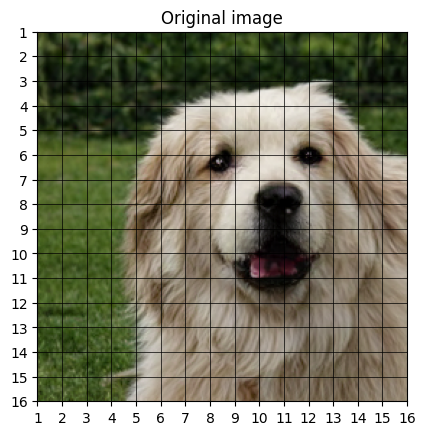

Optimizing image:   0%|          | 0/10000 [00:00<?, ?it/s]/home/myid/ty45972/miniconda3/envs/VQGAN/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 0, Loss: -5.42035436630249


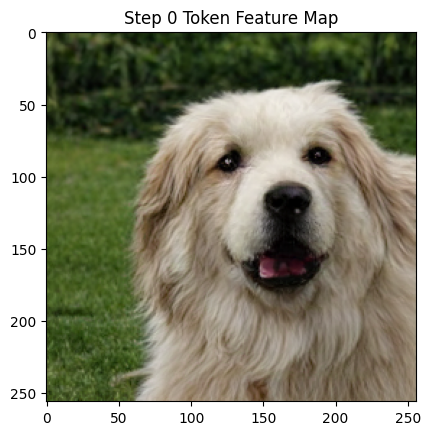

Optimizing image:   1%|          | 95/10000 [00:01<01:58, 83.52it/s] 

Step 100, Loss: -26.503263473510742


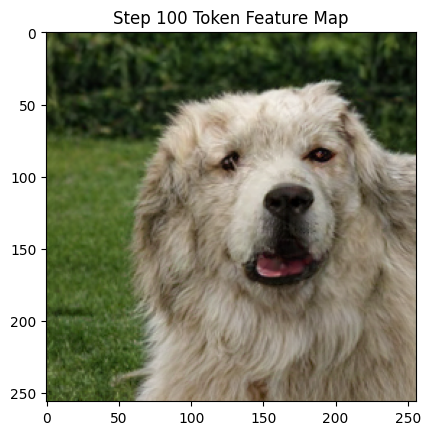

Optimizing image:   2%|▏         | 196/10000 [00:02<01:58, 82.75it/s]

Step 200, Loss: -34.976898193359375


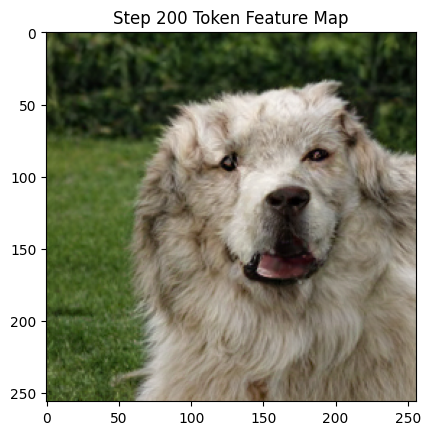

Optimizing image:   5%|▍         | 496/10000 [00:06<01:53, 84.07it/s]

Step 500, Loss: -52.115360260009766


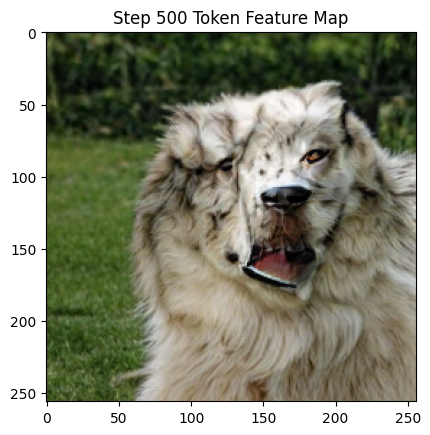

Optimizing image:  10%|▉         | 994/10000 [00:12<01:48, 82.68it/s]

Step 1000, Loss: -59.66901397705078


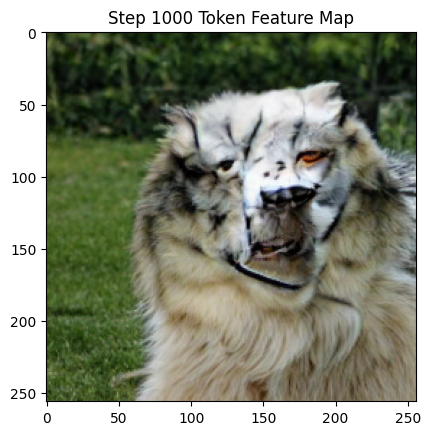

Optimizing image:  20%|█▉        | 1996/10000 [00:24<01:34, 85.02it/s]

Step 2000, Loss: -63.98225021362305


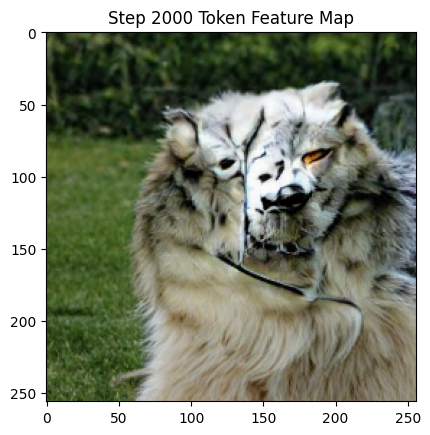

Optimizing image:  50%|████▉     | 4996/10000 [01:00<00:58, 85.22it/s]

Step 5000, Loss: -68.19661712646484


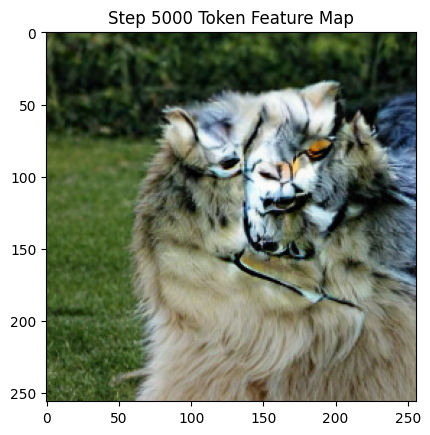

Optimizing image: 100%|██████████| 10000/10000 [01:59<00:00, 83.49it/s]


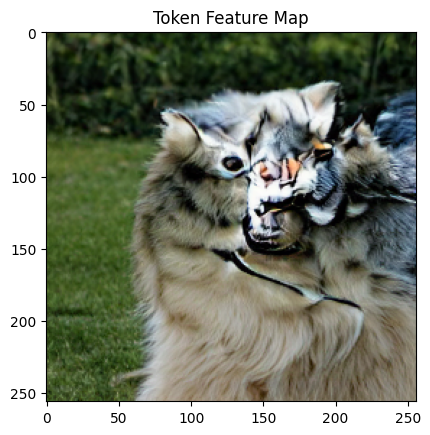

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import argparse
from tqdm import tqdm
from model import ClassificationNet1, ClassificationNet2, ClassificationNet3
import os
from omegaconf import OmegaConf
import sys
from datetime import datetime
from einops import rearrange
from PIL import Image
import matplotlib.pyplot as plt

import sys
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
current_directory = os.getcwd()

# 获取父目录
parent_directory = os.path.abspath(os.path.join(current_directory, '..'))

# 添加到sys.path
sys.path.append(parent_directory)
from taming.models.new_vqgan import VQModel, GumbelVQ
from einops import rearrange
from PIL import Image
import matplotlib.pyplot as plt

rescale = lambda x: (x + 1.) / 2.

# Convert CHW tensor to a PIL image
def chw_to_pillow(x):
    return Image.fromarray((255*rescale(x.detach().cpu().numpy().transpose(1,2,0))).clip(0,255).astype(np.uint8))

# Load classification model
def load_classification_model(model_choice, model_path, device):
    num_classes = 1000  # 假设有1000个类别，可以根据实际情况调整
    if model_choice == 1:
        model = ClassificationNet1(num_classes)
    elif model_choice == 2:
        model = ClassificationNet2(num_classes)
    elif model_choice == 3:
        model = ClassificationNet3(num_classes)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Generate maximum activation image with partial optimization
def generate_max_activation_image(model, target_label, device, input_shape=(1, 256, 16, 16), lr=0.005, num_steps=10000, reg=0, VQ_model=None, mask=None, initial_embedding=None, save_path=None):
    # Initialize input image
    input_embedding = initial_embedding.clone().detach().requires_grad_(True).to(device)
    
    if mask is not None:
        mask = mask.to(device)

    # Define optimizer
    optimizer = torch.optim.Adam([input_embedding], lr=lr)
    
    for step in tqdm(range(num_steps), desc="Optimizing image"):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(input_embedding)
        
        # Loss function: maximize target class activation with regularization
        loss = -output[0, target_label] + reg * torch.mean(input_embedding ** 2)  # Negative activation to maximize
        
        # Backward pass
        loss.backward()
        
        if mask is not None:
            input_embedding.grad *= mask
        
        # Update input image
        optimizer.step()
        
        # Save image and print loss at certain steps
        if step == 0 or step == 100 or step == 200 or step == 500 or step == 1000 or step == 2000 or step == 5000:
            print(f"Step {step}, Loss: {loss.item()}")
            # Decode and save the current embedding
            _, _, token_feature_maps, _ = decode_input_embedding(input_embedding, VQ_model)
            for i, token_feature_map in enumerate(token_feature_maps):
                token_feature_map_img = chw_to_pillow(token_feature_map)
                plt.imshow(token_feature_map_img)
                plt.title(f"Step {step} Token Feature Map")
                save_image(token_feature_map_img, save_path, step)
                plt.show()

    return input_embedding

def save_image(image, save_path, step):
    image_file = os.path.join(save_path, f"{step}.png")
    image.save(image_file)

def load_config(config_path):
    return OmegaConf.load(config_path)

# Load VQGAN model
def load_vqgan(config, ckpt_path=None, is_gumbel=False):
    model = VQModel(**config.model.params)
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
        model.load_state_dict(sd, strict=False)
    return model.eval()

# Decode input embedding using VQGAN
def decode_input_embedding(input_embedding, VQ_model):
    codebook = VQ_model.quantize.embedding

    z = rearrange(input_embedding, 'b c h w -> b h w c').contiguous()
    z_flattened = z.view(-1, 256)

    d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
        torch.sum(codebook.weight**2, dim=1) - 2 * \
        torch.einsum('bd,dn->bn', z_flattened, rearrange(codebook.weight, 'n d -> d n'))

    min_encoding_indices = torch.argmin(d, dim=1)

    z_q = codebook(min_encoding_indices).view(z.shape)

    # reshape back to match original input shape
    z_q = rearrange(z_q, 'b h w c -> b c h w').contiguous()
    original_feature_map = VQ_model.decode(input_embedding)
    token_feature_map = VQ_model.decode(z_q)
    return z_q, min_encoding_indices, token_feature_map, original_feature_map

# Define mask to optimize specific regions
def create_mask(input_shape, top_left, bottom_right):
    mask = torch.zeros(input_shape)
    mask[:, :, top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 1
    return mask

# Main function
def main():
    model_number = 1
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    classification_model_path = f"/data/ty45972/taming-transformers/codebook_explanation_classification/checkpoints/generated_data/ClassificationNet{model_number}/best_model.pth"
    classification_model = load_classification_model(model_number, classification_model_path, device)
    
    # Define the label index and target optimization region
    target_label = 269 # Example label
    original_label = 257  # Example original label

    # optimize the face region
    top_left = (3, 5)
    bottom_right = (12, 16)
    
    # optimize the body
    # top_left = (4, 4)
    # bottom_right = (12, 16)

    mask = create_mask((1, 256, 16, 16), top_left, bottom_right)
    
    # Create the directory for saving images
    save_dir = f"outputs/{original_label}_{target_label}_{top_left[0]}_{top_left[1]}"
    os.makedirs(save_dir, exist_ok=True)

    # Load VQGAN model
    config = load_config("../logs/vqgan_imagenet_f16_16384/configs/model.yaml")
    VQ_model = load_vqgan(config, ckpt_path="../logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)
    
    original_image_file = f"/data/ty45972/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_generated/{original_label}/000002.npy"
    image_array = np.load(original_image_file)
    original_image_tensor = torch.tensor(image_array).unsqueeze(0).to(device)
    _, _, original_images, _ = decode_input_embedding(original_image_tensor, VQ_model)
    for original_image in original_images:
        image = chw_to_pillow(original_image)
        plt.imshow(image, extent=[1, 16, 16, 1])
        plt.title("Original image")
        plt.xticks(ticks=range(1, 17))
        plt.yticks(ticks=range(1, 17))
        plt.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
        plt.show()
        save_image(image, save_dir, "original")

    optimized_image_embedding = generate_max_activation_image(classification_model, target_label, device, mask=mask, VQ_model=VQ_model, initial_embedding=original_image_tensor, save_path=save_dir)
    
    quantized_optimized_embedding, token_combination, token_feature_maps, _ = decode_input_embedding(optimized_image_embedding, VQ_model)

    # Visualize and save final results
    for i, token_feature_map in enumerate(token_feature_maps):
        token_feature_map_img = chw_to_pillow(token_feature_map)
        plt.imshow(token_feature_map_img)
        plt.title("Token Feature Map")
        plt.show()
        save_image(token_feature_map_img, save_dir, f"final_{i}")

if __name__ == "__main__":
    main()


### Image improvement

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
self.embedding is torch.Size([16384, 256])


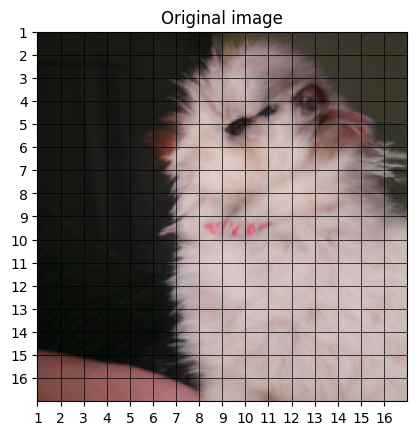

torch.Size([1, 256, 16, 16])


Optimizing image:   0%|          | 0/3000 [00:00<?, ?it/s]

Step 0, Loss: -0.32461053133010864


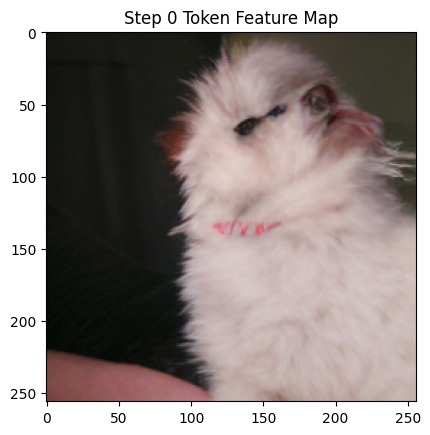

Optimizing image:   6%|▋         | 195/3000 [00:02<00:33, 84.60it/s]

Step 200, Loss: -27.377145767211914


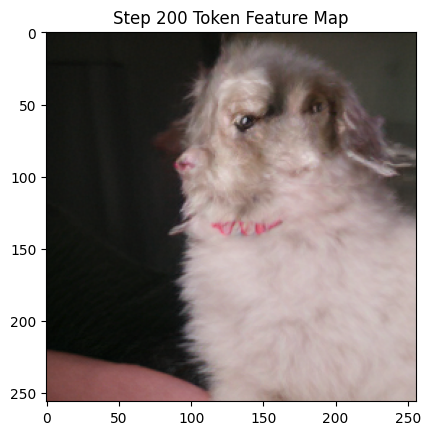

Optimizing image:  13%|█▎        | 395/3000 [00:04<00:30, 84.39it/s]

Step 400, Loss: -31.7709903717041


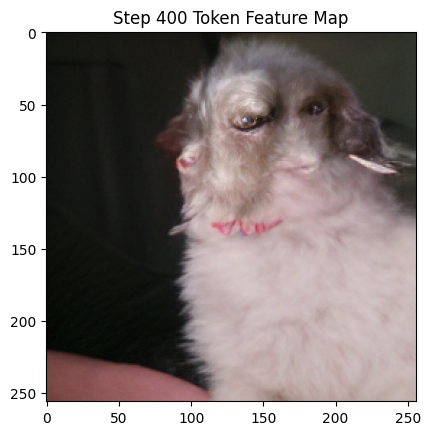

Optimizing image:  20%|█▉        | 597/3000 [00:07<00:28, 84.44it/s]

Step 600, Loss: -33.413578033447266


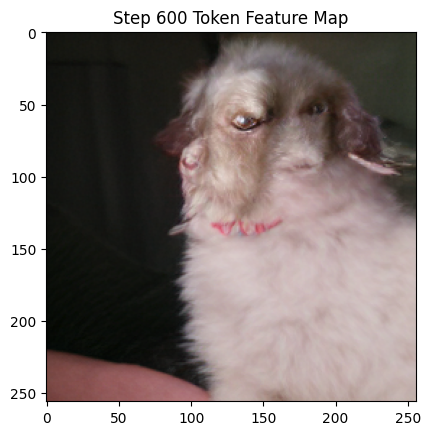

Optimizing image:  27%|██▋       | 796/3000 [00:10<00:26, 84.32it/s]

Step 800, Loss: -35.42509841918945


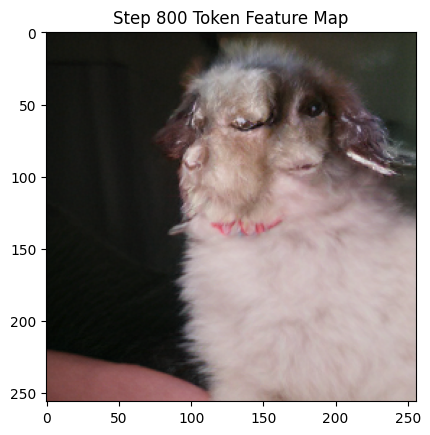

Optimizing image:  33%|███▎      | 997/3000 [00:12<00:23, 84.11it/s]

Step 1000, Loss: -37.04787063598633


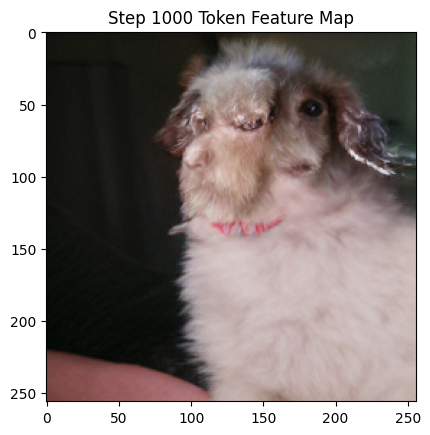

Optimizing image:  40%|███▉      | 1196/3000 [00:15<00:21, 84.07it/s]

Step 1200, Loss: -38.21108627319336


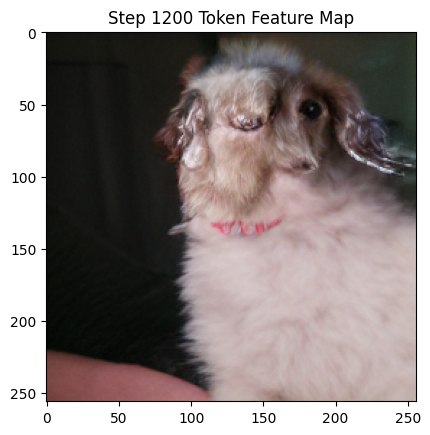

Optimizing image:  47%|████▋     | 1397/3000 [00:17<00:19, 84.16it/s]

Step 1400, Loss: -38.64693069458008


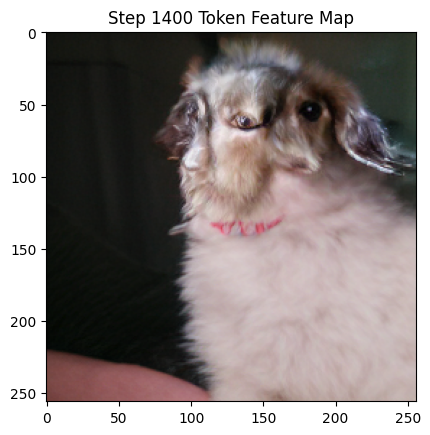

Optimizing image:  53%|█████▎    | 1596/3000 [00:20<00:16, 84.12it/s]

Step 1600, Loss: -38.944427490234375


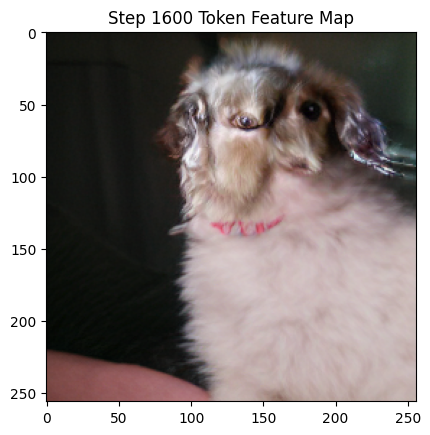

Optimizing image:  60%|█████▉    | 1797/3000 [00:22<00:14, 84.20it/s]

Step 1800, Loss: -39.194671630859375


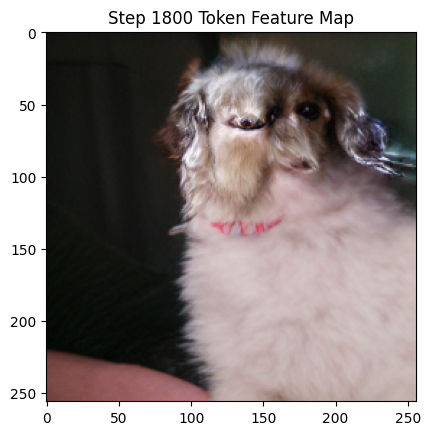

Optimizing image:  66%|██████▋   | 1995/3000 [00:25<00:11, 84.34it/s]

Step 2000, Loss: -39.36568069458008


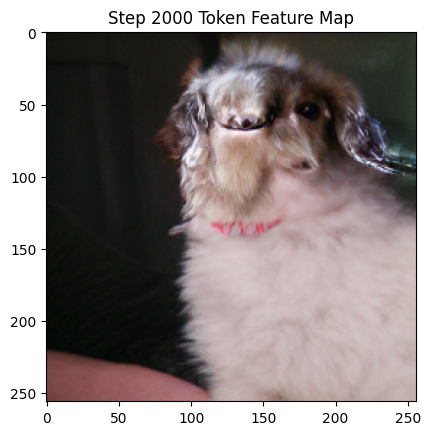

Optimizing image:  72%|███████▏  | 2161/3000 [00:27<00:10, 78.34it/s]


KeyboardInterrupt: 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import argparse
from tqdm import tqdm
from model import ClassificationNet1, ClassificationNet2, ClassificationNet3
import os
from omegaconf import OmegaConf
import sys
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
current_directory = os.getcwd()

# 获取父目录
parent_directory = os.path.abspath(os.path.join(current_directory, '..'))

# 添加到sys.path
sys.path.append(parent_directory)
from taming.models.new_vqgan import VQModel, GumbelVQ
from einops import rearrange
from PIL import Image
import matplotlib.pyplot as plt

rescale = lambda x: (x + 1.) / 2.

# Convert CHW tensor to a PIL image
def chw_to_pillow(x):
    return Image.fromarray((255*rescale(x.detach().cpu().numpy().transpose(1,2,0))).clip(0,255).astype(np.uint8))

# Load classification model
def load_classification_model(model_choice, model_path, device):
    num_classes = 1000  # 假设有1000个类别，可以根据实际情况调整
    if model_choice == 1:
        model = ClassificationNet1(num_classes)
    elif model_choice == 2:
        model = ClassificationNet2(num_classes)
    elif model_choice == 3:
        model = ClassificationNet3(num_classes)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Generate maximum activation image with partial optimization
def generate_max_activation_image(model, target_label, device, input_shape=(1, 256, 16, 16), lr=0.01, num_steps=3000, reg=0.01, VQ_model=None, mask=None, initial_embedding=None):
    # Initialize input image
    # input_embedding = torch.randn(input_shape, device=device, requires_grad=True)
    input_embedding = initial_embedding.clone().detach().requires_grad_(True).to(device)
    print(input_embedding.shape)
    if mask is not None:
        mask = mask.to(device)

    # Define optimizer
    optimizer = torch.optim.Adam([input_embedding], lr=lr)
    
    for step in tqdm(range(num_steps), desc="Optimizing image"):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(input_embedding)
        
        # Loss function: maximize target class activation with regularization
        loss = -output[0, target_label] + reg * torch.mean(input_embedding ** 2)  # Negative activation to maximize
        
        # Backward pass
        loss.backward()
        
        if mask is not None:
            input_embedding.grad *= mask
        
        # Update input image
        optimizer.step()
        
        # Print loss
        if step % 200 == 0:
            print(f"Step {step}, Loss: {loss.item()}")
            # Decode and visualize the current embedding
            _, _, token_feature_maps, _ = decode_input_embedding(input_embedding, VQ_model)
            for token_feature_map in token_feature_maps:
                token_feature_map_img = chw_to_pillow(token_feature_map)
                plt.imshow(token_feature_map_img)
                plt.title(f"Step {step} Token Feature Map")
                plt.show()
    return input_embedding

def load_config(config_path):
    return OmegaConf.load(config_path)

# Load VQGAN model
def load_vqgan(config, ckpt_path=None, is_gumbel=False):
    model = VQModel(**config.model.params)
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
        model.load_state_dict(sd, strict=False)
    return model.eval()

# Decode input embedding using VQGAN
def decode_input_embedding(input_embedding, VQ_model):
    codebook = VQ_model.quantize.embedding

    z = rearrange(input_embedding, 'b c h w -> b h w c').contiguous()
    z_flattened = z.view(-1, 256)
    # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

    d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
        torch.sum(codebook.weight**2, dim=1) - 2 * \
        torch.einsum('bd,dn->bn', z_flattened, rearrange(codebook.weight, 'n d -> d n'))

    min_encoding_indices = torch.argmin(d, dim=1)

    z_q = codebook(min_encoding_indices).view(z.shape)

    # reshape back to match original input shape
    z_q = rearrange(z_q, 'b h w c -> b c h w').contiguous()
    original_feature_map = VQ_model.decode(input_embedding)
    token_feature_map = VQ_model.decode(z_q)
    return z_q, min_encoding_indices, token_feature_map, original_feature_map

# Define mask to optimize specific regions
def create_mask(input_shape, top_left, bottom_right):
    mask = torch.zeros(input_shape)
    mask[:, :, top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 1
    return mask

# Main function
def main():
    model_number = 1
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    classification_model_path = f"/data/ty45972/taming-transformers/codebook_explanation_classification/checkpoints/generated_data/ClassificationNet{model_number}/best_model.pth"
    classification_model = load_classification_model(model_number, classification_model_path, device)
    
    
    # Define the label index and target optimization region
    target_label = 205  # Example label 
    # target_label = 14
    
    # top_left = (5, 3)
    # bottom_right = (12, 16)
    top_left = (1, 5)
    bottom_right = (7, 15)


    
    mask = create_mask((1, 256, 16, 16), top_left, bottom_right)
    

    # Load VQGAN model
    config = load_config("../logs/vqgan_imagenet_f16_16384/configs/model.yaml")
    VQ_model = load_vqgan(config, ckpt_path="../logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)
    
    original_image_file = "/data/ty45972/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_generated/204/000015.npy"
    image_array = np.load(original_image_file)
    original_image_tensor = torch.tensor(image_array).unsqueeze(0).to(device)
    _, _, original_images, _ = decode_input_embedding(original_image_tensor, VQ_model)
    for original_image in original_images:
        image = chw_to_pillow(original_image)
        # 绘制图像并设置坐标范围
        plt.imshow(image, extent=[1, 17, 17, 1])
        plt.title("Original image")
        
        # 设置x轴和y轴的坐标刻度
        plt.xticks(ticks=range(1, 17))  # x轴从1到16
        plt.yticks(ticks=range(1, 17))  # y轴从1到16
        
        # 添加网格线以更好地区分patch
        plt.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
        
        plt.show()

    optimized_image_embedding = generate_max_activation_image(classification_model, target_label, device, mask=mask, VQ_model=VQ_model, initial_embedding=original_image_tensor)


    quantized_optimized_embedding, token_combination, token_feature_maps, _ = decode_input_embedding(optimized_image_embedding, VQ_model)

    # Generate max activation image

    
    # Visualize final results
    for token_feature_map in token_feature_maps:
        token_feature_map_img = chw_to_pillow(token_feature_map)
        plt.imshow(token_feature_map_img)
        plt.title("Token Feature Map")
        plt.show()

if __name__ == "__main__":
    

    main()